In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Config

In [3]:
dataset = "v3_drop_cancer_stem_drop_cholangiocytes_no_normals_min2"

base = f"/data/users/{os.environ['USER']}/EcoTyper"
raw_data_dir = f"{base}/data/scRNA/merged_seurat/ecotyper_friendly"
state_assignment_data_dir = f"{base}/results/{dataset}"

enrichment_data_dir = f"{base}/gsea_enrichment/{dataset}" 
expression_data = f"{raw_data_dir}/{dataset[3:-5]}.expression.tsv"
annotation = f"{raw_data_dir}/{dataset[3:-5]}.annotation.tsv"

cell_cycle_marker_genes = f"{base}/data/scRNA/v1/resources/cyclebaseGeneList.txt"

final = f"{base}/summaries/{dataset}.cell_cycle_expression.tsv"

Define patterns to search for when parsing "gene expression"-related gene sets

In [4]:
expression_patterns = [
                "translation",
                "rRNA",
                "ribosom",
                "peptide chain",
                "elongation",
                "peptide chain initiation",
                "peptide chain termination",
                "40S",
                "60S",
                "80S",
                "ribosom(e|al)",
                "gene expression",
                "transcription(al)?",
                "RNA polymerase",
                "tRNA",
                "production.*protein",
                "protein production",
                "DNA replication",
]

Read the input data

In [5]:
annotation = pd.read_csv(annotation, sep="\t", index_col=0)
markers = pd.read_csv(cell_cycle_marker_genes, sep="\t", index_col=0)

if not os.path.exists(final):
    expression = pd.read_csv(expression_data, sep="\t", index_col=0)
    genes_found = len(set(markers.index.values).intersection(set(expression.index.values)))
    assert genes_found > 0, "No cell cycle marker genes found in expression data"
    expression = expression[expression.index.isin(markers.index.values)]
    expression.shape

Define helper functions

In [6]:
def get_genes_to_state(df, state):
    cells = df[df["State"] == state].ID.values
    _expressions = expression[expression.columns.intersection(cells)]
    return _expressions

def compute_phase_expression(expressions):
    _expressions = expressions.copy()
    _expressions["phase"] = markers["Peaktime"]

    _expr = {}
    for i, _df in _expressions.groupby("phase"):
        _df.drop("phase", axis=1, inplace=True)
        _expr[i] = [_df.values.flatten().mean()]
    
    _expressions = pd.DataFrame(_expr).T
    _expressions.columns = ["expression"]
    _expressions.index.name = "phase"
    return _expressions

def split_filename(filename):
    filename = os.path.basename(filename)
    celltype, state = filename.split(".txt.enrichr.txt")[0].split("_S")
    state = "S" + state
    return celltype, state

def get_pattern_enrichment(filename):
    df = pd.read_csv(filename, sep="\t")
    mask = df["Term"].str.contains("|".join(expression_patterns))
    scores = np.log2(df[mask]["Combined Score"].values)
    qvals = -np.log10(df[mask]["Adjusted P-value"].values)
    mean_score = np.mean(scores * qvals)
    return mean_score


# Parse data

Get the average expression of cell cycle marker genes

In [26]:
if not os.path.exists(final):
        
    ecotypes = glob.glob(enrichment_data_dir + "/E*")

    cell_cycle_df = []
    assignments = {}

    for ecotype in ecotypes:

        # get all enrichments
        enrichments = glob.glob(ecotype + "/*.txt.enrichr.txt")

        # get marker expression for each cell type
        for file in enrichments:

            celltype, state = split_filename(file)

            if celltype not in assignments:

                assignment_file = f"{state_assignment_data_dir}/{celltype}/state_assignment.txt"
                assignments[celltype] = pd.read_csv(assignment_file, sep="\t", index_col=0)
            
            _expressions = assignments[celltype]
            _expressions = get_genes_to_state(_expressions, state)
            

            _expressions = compute_phase_expression(_expressions)

            _expressions["expression"] = _expressions["expression"] / _expressions["expression"].max()
            _expressions["celltype"] = celltype
            _expressions["state"] = state
            _expressions["ecotype"] = os.path.basename(ecotype)

            # get division pattern enrichment
            enrichment_file = f"{enrichment_data_dir}/{os.path.basename(ecotype)}/{celltype}_{state}.txt.enrichr.txt"
            _expressions["pattern_enrichment"] = get_pattern_enrichment(enrichment_file)

            cell_cycle_df.append(_expressions)

    cell_cycle_df = pd.concat(cell_cycle_df)
    cell_cycle_df = cell_cycle_df.reset_index()

    cell_cycle_df["pattern_enrichment"] = cell_cycle_df["pattern_enrichment"] / cell_cycle_df["pattern_enrichment"].max()

    cell_cycle_df.to_csv(final, sep="\t", index=False)

else:

    cell_cycle_df = pd.read_csv(final, sep="\t", index_col=0)

In [27]:
cell_cycle_df

,expression,celltype,state,ecotype,pattern_enrichment
phase,,,,,
G1,66.937001,Hepatoblasts,S01,E6,3.473737
G1/S,33.070884,Hepatoblasts,S01,E6,3.473737
G2,67.531251,Hepatoblasts,S01,E6,3.473737
G2/M,24.392010,Hepatoblasts,S01,E6,3.473737
M,45.516627,Hepatoblasts,S01,E6,3.473737
...,...,...,...,...,...
G1/S,47.590151,Endothelial_cell,S07,E5,6.028231
G2,62.450157,Endothelial_cell,S07,E5,6.028231
G2/M,55.132795,Endothelial_cell,S07,E5,6.028231


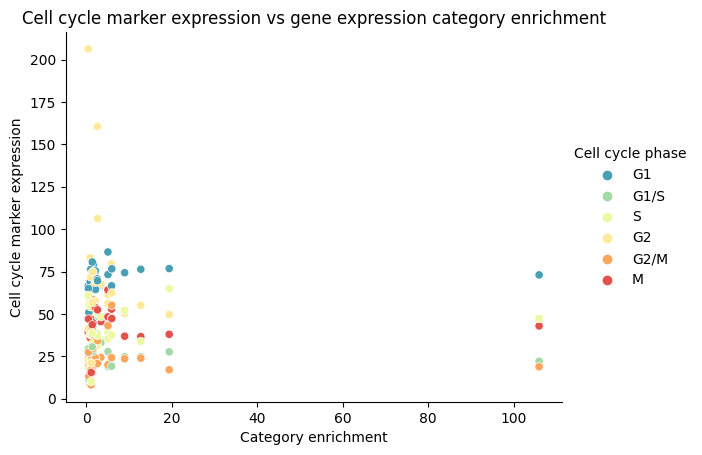

In [28]:
ax = sns.scatterplot(data=cell_cycle_df, x="pattern_enrichment", y="expression", hue="phase", hue_order = ['G1', 'G1/S', 'S', 'G2', 'G2/M', 'M'], palette="Spectral_r")
ax.set(title = "Cell cycle marker expression vs gene expression category enrichment", xlabel = "Category enrichment", ylabel = "Cell cycle marker expression")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title = "Cell cycle phase")
sns.despine()

In [39]:
ax.figure.savefig(final.replace(".tsv", ".png"), bbox_inches='tight', dpi=500)

Now perform a statistical analysis to check the predictive value of the category enrichment for cell cycle phase

In [40]:
cell_cycle_df["celltype"] = cell_cycle_df["celltype"].astype("category")

formula = "expression ~ pattern_enrichment" # + (1 + pattern_enrichment | celltype)"
model = smf.mixedlm(formula, cell_cycle_df, groups=cell_cycle_df["celltype"])
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  expression
No. Observations:    168      Method:              REML      
No. Groups:          9        Scale:               590.3174  
Min. group size:     6        Log-Likelihood:      -777.2031 
Max. group size:     30       Converged:           Yes       
Mean group size:     18.7                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          44.842    3.697 12.129 0.000 37.596 52.088
pattern_enrichment -0.022    0.127 -0.170 0.865 -0.271  0.227
Group Var          67.497    2.064                           
=============================================================

"""